In [1]:
from pathlib import Path

import pandas as pd
import ee
import numpy as np
from tqdm.notebook import tqdm

# from tqdm import tqdm
import geopandas as gpd
from sepal_ui import aoi
from sepal_ui import sepalwidgets as sw
from sepal_ui.scripts import gee
from osgeo import gdal
import rasterio as rio

import dask.array as da
import dask.dataframe as dd

from component import parameter as pm
from component.scripts import gdrive

Styles()

ResizeTrigger()

In [2]:
ee.Initialize()

In [3]:
drive_handler = gdrive()

# Load all the data provided in se.plan as a csv 

This proces has been setup to extract from earthengine all the information required to run se.plan analysis in STATA a software that is not intended for Geospatial data. Here we will export as a single CSV all non mask pixels of 1km from se.plan layers + their lattitude, longitude, surface and administrative names

In [4]:
# init the downloading path
save_dir = Path.home() / "module_results" / "se.plan_csv"
save_dir.mkdir(exist_ok=True, parents=True)

raw_dir = save_dir / "raw_data"
raw_dir.mkdir(exist_ok=True)

csv_dir = save_dir / "raw_csv"
csv_dir.mkdir(exist_ok=True)

dafatrames_dir = save_dir / "raw_final"
dafatrames_dir.mkdir(exist_ok=True)

In [5]:
# get the country list
lmic_list = pd.read_csv(pm.country_list)

lmic_list.head()

,Country,Official name,ISO3,ISO2,UNI,UNDP,FAOSTAT,GAUL
0,Afghanistan,the Islamic Republic of Afghanistan,AFG,AF,4.0,AFG,2.0,1
1,Algeria,the People's Democratic Republic of Algeria,DZA,DZ,12.0,DZA,4.0,4
2,Angola,the Republic of Angola,AGO,AO,24.0,AGO,7.0,8
3,Antigua and Barbuda,Antigua and Barbuda,ATG,AG,28.0,ATG,8.0,11
4,Argentina,the Argentine Republic,ARG,AR,32.0,ARG,9.0,12


In [6]:
# get all the layers
layer_list = pd.read_csv(
    pm.layer_list, usecols=["layer_id", "theme", "gee_asset"]
).sort_values(by=["theme"])

layer_list.head()

,layer_id,theme,gee_asset
0,woodfuel_harvest,benefit,projects/john-ee-282116/assets/fao-restoration...
1,plantation_growth_rates,benefit,projects/john-ee-282116/assets/fao-restoration...
3,forest_job,benefit,projects/john-ee-282116/assets/fao-restoration...
4,ground_carbon,benefit,projects/john-ee-282116/assets/fao-restoration...
5,biodiversity_intactness,benefit,projects/john-ee-282116/assets/fao-restoration...


In [7]:
# create the reference parameters
name = "treecover_with_potential"
layer = layer_list[layer_list.layer_id == name].iloc[0]

ee_ref = ee.Image(layer.gee_asset)
ee_ref_crs = ee_ref.projection()

# the image is not bounded any more I need to draw it manually
# ee_ref_geom = ee_ref.geometry()
ee_ref_geom = ee.Geometry.Polygon(
    coords=[
        [-144.51600549814273, -58.07221137655366],
        [192.42150308492614, -58.07221137655366],
        [192.42150308492614, 57.78491418812651],
        [-144.51600549814273, 57.78491418812651],
        [-144.51600549814273, -58.07221137655366],
    ],
    geodesic=False,
    proj="EPSG:4326",
)


def export_to_drive(name, image):
    """
    Export image to rive using the ref parameters
    If the image is not already exported/exporting

    Args:
        name (str): the name of the asset
        image (ee.Image): the image to export
    """

    if not any(
        [
            len(drive_handler.get_files(f"se.plan/{name}")),
            (save_dir / f"{name}.vrt").is_file(),
            gee.is_running(name),
        ]
    ):
        task_config = {
            "folder": "se.plan",
            "image": image,
            "description": name,
            "region": ee_ref_geom,
            "scale": 1000,
            "crs": ee_ref_crs,
            "maxPixels": 10e12,
        }

        task = ee.batch.Export.image.toDrive(**task_config)
        task.start()

    return

## extract the LMIC

The low and medium income countries are the default target countries of se.plan. thus this process will only retrieve information from these countries. The shapes will be exported as a geopackage file that can be read by any GIS software. The geometry will also be exported as an image to be used in the csv further down the script 

In [8]:
# use the sepal_ui defined aoi_model object to retreive aoi from GADM using their country code
aoi_model = aoi.AoiModel(alert=sw.Alert(), gee=False)

/tmp/ipykernel_496/3398141369.py:2: DeprecationWarning: Call to deprecated method __init__. (`alert` positional argument will be removed. Successfull output messages has to be created in AoiView.) -- Deprecated since version 2.11.3.
  aoi_model = aoi.AoiModel(alert=sw.Alert(), gee=False)


In [9]:
# create a sublist of countries using the iso_3 code based on the aoi_model file
country_list = pd.read_csv(aoi_model.FILE[0])  # GADM based

In [10]:
def level0_gdf(admin):
    """
    return a clomplete gdf for each country at level 0 but including the level 1 information

    a function to create a composite gdf from the gadm exported countries
    the main trick is to read all the countries even the one that have no level 1 data

    Args:
        admin (int): the admin number GID_0

    Return:
        (goedataframe): the geodataframe of the country
    """

    # get all the sub administrative areas
    df = country_list[country_list.GID_0 == admin]  # only the featured country
    df = df.drop_duplicates(subset="GID_1")  # remove all GID_2

    # get all the admin numbers
    gdf = None
    for i, row in df.iterrows():

        admin = row.GID_1 if row.GID_1 and row.GID_1 == row.GID_1 else row.GID_0

        aoi_model.admin = admin
        aoi_model.set_object(method="ADMIN0")  # any admin level do the same

        tmp_gdf = aoi_model.gdf
        gdf = tmp_gdf if gdf is None else pd.concat([gdf, tmp_gdf])

    return gdf

In [11]:
# save the countries as a geopackage
# skip this step if the countries have already been exported
gid_path = save_dir / "lmic_leve1.gpkg"

if gid_path.is_file():

    # read the file
    gdf = gpd.read_file(gid_path, layer="GID")

else:
    gdf = None
    with tqdm(total=len(lmic_list), desc="loading countries") as pbar:
        for i, row in lmic_list.iterrows():

            tmp_gdf = level0_gdf(row.ISO3)
            gdf = tmp_gdf if gdf is None else pd.concat([gdf, tmp_gdf])

            pbar.update()

    gdf.to_file(gid_path, driver="GPKG", layer="GID")

loading countries:   0%|          | 0/139 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [12]:
# check that all the countries are included
if len(gdf.GID_0.unique()) != 139:
    raise ValeuError(
        f"Their are 139 LMIC countries which is not corresponding to the {len(gdf.GID_0.unique())} provided"
    )

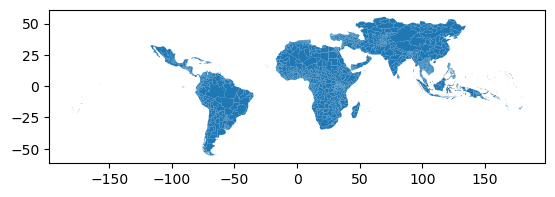

In [13]:
# plot the countries
gdf.plot()

In [ ]:
# export an admin level as a gee image to drive
def export_admin(level):
    """
    Export a specific level of the lmic country list as an image aligned on the reference

    Args:
        level (int): the admin level value to export
    """

    layer = "projects/john-ee-282116/assets/fao-restoration/features/rest_pot_gt_treecoverfrac_mask_urban"
    ee_ref_crs = ee.Projection(ee.Image(layer).projection())
    ee_lmic_list = ee.List(list(lmic_list.GAUL.values))

    ee_lmic = (
        ee.FeatureCollection("FAO/GAUL/2015/level1")
        .filter(ee.Filter.inList("ADM0_CODE", ee_lmic_list))
        .reduceToImage(properties=[f"ADM{level}_CODE"], reducer=ee.Reducer.first())
        .select("first")
        .rename(f"ADM{level}_CODE")
        .setDefaultProjection(crs=ee_ref_crs)
        .reduceResolution(reducer=ee.Reducer.mode(), maxPixels=2048)
    )

    export_to_drive(f"ADM{level}_CODE", ee_lmic)

    return


# add the 2 admin export to the database
# for i in range(2):
#    name = f"ADM{i}_CODE"
#    # buged at the moment I did it manually (https://code.earthengine.google.com/cb4d25f32e0d9f94c7ce68263d752d19)
#    export_admin(i)
#    if not name in layer_list.layer_id:
#        layer_list.loc[len(layer_list)] = [f"ADM{i}_CODE", f"ADM{i}_CODE", ""]

In [ ]:
# add potential_treecover to layers
layer_list.loc[len(layer_list)] = [
    "potential_treecover",
    "",
    "users/yelenafinegold/bastin2019/restoration_potential",
]

In [ ]:
layer_list

## extract the pixel area

It's meaningfull to compute the pixel area as the dataset covers the entire world 

In [ ]:
# get the pixel sizes of the reference as an image
pixel_area = "pixel_area"
water = ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
land_proportion = (
    water.select("transition")
    .mask()
    .Not()
    .mask(water.select("max_extent").mask())
    # .multiply(ee.Image.pixelArea())
    .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=2048)
)
export_to_drive(pixel_area, land_proportion)

# add the layer to the list
if not pixel_area in layer_list.layer_id:
    layer_list.loc[len(layer_list)] = [pixel_area, pixel_area, ""]

In [ ]:
layer_list

## export the 24 normal layers 

Now we are launhing the exportation of all the layer included in se.plan with as gDrive files. The exportation will be monitored here. the next cells cannot be displayed until this step is finished. 

In [ ]:
# download treecover files, add it in the same directoryand to the layer list
treecover = "current_treecover"
ee_treecover = (
    ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")
    .select("tree-coverfraction")
    .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=2048)
)

export_to_drive(treecover, ee_treecover)

# add the layer to the list
if not treecover in layer_list.layer_id:
    layer_list.loc[len(layer_list)] = [treecover, treecover, ""]

In [ ]:
# filter the original layers
original_layers = layer_list[layer_list.gee_asset != ""]
len(original_layers)
original_layers

In [14]:
filter_layer = layer_list[layer_list.layer_id.isin(["treecover_with_potential"])]
filter_layer

,layer_id,theme,gee_asset
19,treecover_with_potential,constraint,projects/john-ee-282116/assets/fao-restoration...


In [15]:
# export all the layers with the adapted reducer
with tqdm(total=len(filter_layer), desc="export original layers") as pbar:
    for i, row in filter_layer.iterrows():

        # default behaviour
        ee_reducer = ee.Reducer.mean()

        # main mask
        if row.layer_id in ["treecover_with_potential"]:
            ee_reducer = ee.Reducer.anyNonZero()

        # most frequent value
        elif row.layer_id in [
            "protected_areas",
            "ecozones",
            "land_cover",
            "protected_areas",
            "declining_population",
        ]:
            ee_reducer = ee.Reducer.mode()

        image = ee.Image(row.gee_asset.strip())

        # export
        ee_image = (
            ee.Image(row.gee_asset.strip())
            .select(0)
            .reduceResolution(reducer=ee_reducer, maxPixels=2048)
        )
        export_to_drive(row.layer_id, ee_image)

        pbar.update()

print(
    "You can now monitor your exporting steps from earthegine: https://code.earthengine.google.com"
)

export original layers:   0%|          | 0/1 [00:00<?, ?it/s]

You can now monitor your exporting steps from earthegine: https://code.earthengine.google.com


In [ ]:
#############################
# automatic waiting process #
#############################

# TODO

In [ ]:
layer_list.loc[len(layer_list)] = ["lat", "lat", ""]
layer_list.loc[len(layer_list)] = ["lon", "lon", ""]

In [16]:
# once the image are available on my drive
# download theme as files
with tqdm(total=len(filter_layer), desc="retrieve from GDRIVE") as pbar:
    for i, row in filter_layer.iterrows():

        vrt_path = save_dir / f"{row.layer_id}.vrt"

        if vrt_path.is_file():
            pbar.update()
            continue

        files = drive_handler.get_files(row.layer_id)
        files = [f for f in files if "d3_slope" not in f["name"]]
        if len(files):
            loc_files = drive_handler.download_files(files, raw_dir)
            # drive_handler.delete_files(files)

            # create a vrt to manipulate everything
            ds = gdal.BuildVRT(str(vrt_path), [str(f) for f in loc_files])
            ds.FlushCache()

        pbar.update()

retrieve from GDRIVE:   0%|          | 0/1 [00:00<?, ?it/s]

# create the lat and lon files 

as the final file will be an csv lat and lon of the data need to be extracted. To do that we will simply extract the resolution of the ref layer and create a grid out of it. finally we add the pixelSize for each row and column. 

In [ ]:
# extract the reference file characteristics
ref_file = save_dir / "treecover_with_potential.vrt"
with rio.open(ref_file) as mask_f:

    pixelSizes = mask_f.res
    mask_shape = mask_f.read(1).shape
    kwargs = mask_f.meta.copy()
    grid = np.indices(mask_shape)

In [ ]:
# def export_corrdinates(name, column):
#    """
#    export the lat and lon corrdinates of the center of the pixel as images
#
#    Args:
#        name (str): the name of the output
#        column (str): either or not the value is the coumn of the grid
#
#    Return:
#        (path): the raw file
#    """
#
#
#    coord = ee.Image.pixelLonLat().select("longitude")
#
#    Export.image.toDrive({
#  image: lat,
#  folder: "se.plan",
#  description: "lon",
#  region: ee_ref_geom,
#  scale: 1000,
#  crs: "EPSG:4326",
#  maxPixels: 10e12
# })
#
#    raw_file = save_dir / "raw_data" / f"{name}.tif"
#
#    if raw_file.is_file():
#        return raw_file
#
#    data = grid[column] * pixelSizes[column] + pixelSizes[column] / 2
#
#    dtype = rio.dtypes.get_minimum_dtype(data)
#    kwargs["dtype"] = dtype
#    kwargs["driver"] = "GTiff"
#
#    with rio.open(raw_file, "w", **kwargs) as dst:
#        dst.write(data.astype(dtype), 1)
#
#    return raw_file

In [ ]:
# generate lat and long files
coords = [
    {"name": "lon", "column": 0},
    {"name": "lat", "column": 1},
]

for coord in coords:

    name = coord["name"]

    raw_file = export_corrdinates(**coord)

    vrt_file = save_dir / f"{name}.vrt"
    ds = gdal.BuildVRT(str(vrt_file), [str(raw_file)])
    ds.FlushCache()

    if not name in layer_list.layer_id.values:
        layer_list.loc[len(layer_list)] = [name, name, ""]

In [ ]:
len(layer_list)

## assemble all vrts as a single dataframe

to export to csv every vrts are assembled as a single dataframe 
then we exclude all the rows with masked by the ref image 
and we export as csv to the save_directory

In [ ]:
filter_list = layer_list[layer_list.layer_id.isin(["ADM0_CODE", "ADM1_CODE"])]
filter_list

In [17]:
# get the data mask
ref_file = save_dir / "treecover_with_potential.vrt"
with rio.open(ref_file) as mask_f:

    # do it on a window for testing purposes
    # window = mask_f.block_window(1, 0, 0)

    mask = mask_f.read(1)
    mask = mask != 0

with tqdm(total=len(filter_layer), desc="extract data by layer") as pbar:
    for _, r in filter_layer.iterrows():
        name = r.layer_id

        vrt_file = save_dir / f"{name}.vrt"
        df_file = csv_dir / f"{name}.csv"

        if not df_file.is_file():

            with rio.open(vrt_file) as vrt:
                raw = vrt.read(1)[mask].flatten()
                np.savetxt(df_file, np.array(raw), delimiter=",", fmt="%.10f")

        pbar.update()

extract data by layer:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# aggregate all the csv as a dataframe
all_files = csv_dir.glob("*.csv")

# create the init dataframe
# consume the first dataframe of the generator
f = next(all_files)
final_df = (
    dd.read_csv(f, header=None, names=[f.stem])
    .repartition(npartitions=500)
    .reset_index(drop=True)
)

final_df = final_df.assign(
    **{
        f.stem: dd.read_csv(f, header=None, names=[f.stem])
        .repartition(npartitions=500)
        .reset_index(drop=True)[f.stem]
        for f in all_files
    }
)

final_df.head()

In [ ]:
# 50 partitions is compatible with a r8 AWS instance
final_file = dafatrames_dir / "*.csv"
final_df.repartition(npartitions=50).to_csv(final_file, index=False)

In [ ]:
final_df.info()

In [ ]:
# awk '(NR == 1) || (FNR > 1)' file*.csv > bigfile.csv

In [ ]:
# print the 2 first lines
with (save_dir / "dataset.csv").open() as f:
    print(f.readline())
    print(f.readline())

## Build single csv for debugging purpose

In [ ]:
for i, row in layer_list.iterrows():

    # default behaviour
    ee_reducer = ee.Reducer.mean()

    # main mask
    if row.layer_id in ["treecover_with_potential"]:
        ee_reducer = ee.Reducer.anyNonZero()

    # most frequent value
    elif row.layer_id in [
        "protected_areas",
        "ecozones",
        "land_cover",
        "protected_areas",
        "declining_population",
    ]:
        ee_reducer = ee.Reducer.mode()

    # export
    ee_image = (
        ee.Image(row.gee_asset.strip())
        .select(0)
        .reduceResolution(reducer=ee_reducer, maxPixels=2048)
    )
    export_to_drive(row.layer_id, ee_image)

    pbar.update()

##  extra tests for specific datasets

In [ ]:
# check lat long
import numpy as np

lat = csv_dir / "lat.csv"
np_lat = np.genfromtxt(lat, delimiter=",")
print(np.min(np_lat))
print(np.max(np_lat))
print(len(np_lat))

In [ ]:
lon = csv_dir / "lon.csv"
np_lon = np.genfromtxt(lon, delimiter=",")
print(np.min(np_lon))
print(np.max(np_lon))
print(len(np_lon))

In [ ]:
mask = csv_dir / "treecover_with_potential.csv"
np_mask = np.genfromtxt(lon, delimiter=",")
len(np_mask)

In [ ]:
import pandas as pd

adm0 = csv_dir / "ADM0_CODE.csv"
np_adm0 = np.genfromtxt(adm0, delimiter=",")
print(len(np_adm0))

adm0_sepal_ui = Path("/home/prambaud/libs/sepal_ui/sepal_ui/scripts/gaul_database.csv")
print(adm0_sepal_ui.is_file())

np_sepal_ui = pd.read_csv(adm0_sepal_ui).ADM0_CODE.unique()

np.unique(np_adm0[~np.isin(np_adm0, np_sepal_ui)], return_counts=True)

In [ ]:
import pandas as pd

adm1 = csv_dir / "ADM1_CODE.csv"
np_adm1 = np.genfromtxt(adm1, delimiter=",")
print(len(np_adm0))

adm1_sepal_ui = Path("/home/prambaud/libs/sepal_ui/sepal_ui/scripts/gaul_database.csv")
print(adm1_sepal_ui.is_file())

np_sepal_ui = pd.read_csv(adm1_sepal_ui).ADM1_CODE.unique()

np.unique(np_adm1[~np.isin(np_adm1, np_sepal_ui)], return_counts=True)

In [ ]:
40534489 / 106816099

In [ ]:
np.unique(np_adm0, return_counts=True)

In [ ]:
import pandas as pd
import numpy as np

declining_population = csv_dir / "declining_population.csv"
np_declining_population = np.genfromtxt(declining_population, delimiter=",")
print(len(np_declining_population))

print(np.unique(np_declining_population, return_counts=True))

print(107274 / 106816099)
print(75512734 / 106816099)
print(31196091 / 106816099)

In [ ]:
import pandas as pd
import numpy as np

slope = csv_dir / "slope.csv"
np_slope = np.genfromtxt(slope, delimiter=",")
print(len(np_slope))

print(np.count_nonzero(np.isnan(np_slope)))
print(np.min(np_slope))
print(np.max(np_slope))

In [ ]:
filter_layer

In [ ]:
import pandas as pd
import numpy as np

implementation_cost = csv_dir / "implementation_cost.csv"
np_implementation_cost = np.genfromtxt(implementation_cost, delimiter=",")
print(len(np_implementation_cost))

print(np.count_nonzero(np.isnan(np_implementation_cost)))
print(np.min(np_implementation_cost))
print(np.max(np_implementation_cost))

In [ ]:
import pandas as pd
import numpy as np

natural_regeneration = csv_dir / "natural_regeneration.csv"
np_natural_regeneration = np.genfromtxt(natural_regeneration, delimiter=",")
print(len(np_natural_regeneration))

print(np.count_nonzero(np.isnan(np_natural_regeneration)))
print(np.min(np_natural_regeneration))
print(np.max(np_natural_regeneration))

In [ ]:
import pandas as pd
import numpy as np

opportunity_cost = csv_dir / "opportunity_cost.csv"
np_opportunity_cost = np.genfromtxt(opportunity_cost, delimiter=",")
print(len(np_opportunity_cost))

print(np.count_nonzero(np.isnan(np_opportunity_cost)))
print(np.min(np_opportunity_cost))
print(np.max(np_opportunity_cost))

In [ ]:
import pandas as pd
import numpy as np

property_rights = csv_dir / "property_rights.csv"
np_property_rights = np.genfromtxt(property_rights, delimiter=",")
print(len(np_property_rights))

print(np.count_nonzero(np.isnan(np_property_rights)))
print(np.min(np_property_rights))
print(np.max(np_property_rights))

In [ ]:
import pandas as pd
import numpy as np

woodfuel_harvest = csv_dir / "woodfuel_harvest.csv"
np_woodfuel_harvest = np.genfromtxt(woodfuel_harvest, delimiter=",")
print(len(np_woodfuel_harvest))

print(np.count_nonzero(np.isnan(np_woodfuel_harvest)))
print(np.min(np_woodfuel_harvest))
print(np.max(np_woodfuel_harvest))

In [ ]:
import pandas as pd
import numpy as np

forest_job = csv_dir / "forest_job.csv"
np_forest_job = np.genfromtxt(forest_job, delimiter=",")
print(len(np_forest_job))

print(np.count_nonzero(np.isnan(np_forest_job)))
print(np.min(np_forest_job))
print(np.max(np_forest_job))

In [ ]:
import numpy as np

pixel_area = csv_dir / "pixel_area.csv"
np_pixel_area = np.genfromtxt(pixel_area, delimiter=",")
print(np.min(np_pixel_area))
print(np.max(np_pixel_area))
print(np.mean(np_pixel_area))
print(np.count_nonzero(np.isnan(np_pixel_area)))
print(len(np_pixel_area))

In [ ]:
import numpy as np

potential_treecover = csv_dir / "potential_treecover.csv"
potential_treecover = np.genfromtxt(potential_treecover, delimiter=",")
print(np.nanmin(potential_treecover))
print(np.nanmax(potential_treecover))
print(np.count_nonzero(np.isnan(potential_treecover)))
print(len(potential_treecover))

In [ ]:
50138417 / 106816099

In [18]:
import numpy as np

treecover_with_potential = csv_dir / "treecover_with_potential.csv"
treecover_with_potential = np.genfromtxt(treecover_with_potential, delimiter=",")
print(len(treecover_with_potential))

106816099
